In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
import sys
import time
import h5py
import numpy as np
from pathlib import Path
from utils import simulation2d as project
from flowrec.data import data_partition, DataMetadata
import flowrec.training_and_states as train
from flowrec.training_and_states import TrainingState
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from flowrec.models.cnn import Model
import jax 
import jax.numpy as jnp
from jax import lax
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from jax.tree_util import tree_map, Partial
from utils.system import on_which_platform
import chex

train_test_split = [50,100,100]
# train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,3]
cnn_filter = [(3,3)]
dropout_rate = 0.00
regularisation_strength = 0.0000
epochs = 80000
nb_batches = 6
re = 100
data_dir = Path("./local_data/re"+str(re))
dt = 0.0002*625
dx = 12/512
dy = 4/128
sensor_slicing_space = np.s_[::15,::10] # taking points as sensors
weighting = [0.1,0.9] # weighting terms for [physics,sensors]
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
######### delete last rows
x = x[:,:,:250,:]

data_randseed = np.random.randint(1,1000000)
[x_train,x_val,x_test], _ = data_partition(x,1,train_test_split,REMOVE_MEAN=False,randseed=data_randseed,SHUFFLE=False) # Do not shuffle, do not remove mean for training with physics informed loss


[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

triangle_base_coords = [49,80]
pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

(nt,nx,ny) = ux_train.shape
n_base = pb_train.shape[-1]

# information about the grid
datainfo = DataMetadata(
    re = re,
    discretisation=[dt,dx,dy],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()

mlp_layers.extend([3*nx*ny])

pb_train = np.reshape(pb_train,(train_test_split[0],-1))
pb_val = np.reshape(pb_val,(train_test_split[1],-1))


u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)

# take sensor measurement
sensor_slicing = (np.s_[:],) + sensor_slicing_space

observed_train = u_train[sensor_slicing]
observed_val = u_val[sensor_slicing]

rng = jax.random.PRNGKey(np.random.randint(10,50))
optimizer = optax.adamw(learning_rate=learning_rate,weight_decay=regularisation_strength)

mdl = Model(mlp_layers,output_shape=(nx,ny,3),cnn_channels=cnn_channels,cnn_filters=cnn_filter,dropout_rate=dropout_rate)

In [2]:
datainfo

_Metadata2d(re=100, discretisation=[0.125, 0.0234375, 0.03125], axis_index=[0, 1, 2], axt=0, axx=1, axy=2, dt=0.125, dx=0.0234375, dy=0.03125)

In [3]:
# import logging
# logging.getLogger('fr.flowrec.training_and_states').setLevel(logging.DEBUG)

In [4]:
params = mdl.init(rng,pb_train[0,:]) # initalise weights
opt_state = optimizer.init(params)
state = TrainingState(params, opt_state)

In [5]:
# @jax.jit
def loss_fn_ref(apply_fn,params,rng,x,y,w=[0.5,0.5],**kwargs):
    pred = apply_fn(params, rng, x, **kwargs)
    loss_sensor = losses.mse(pred[sensor_slicing], y)
    
    pred = pred.at[sensor_slicing].set(y)
    loss_div = losses.divergence(pred[...,0], pred[...,1], datainfo)
    loss_mom_x = jnp.mean(derivatives.momentum_residue_field(
                            1,
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2],
                            datainfo=datainfo)**2
                            )
    loss_mom_y = jnp.mean(derivatives.momentum_residue_field(
                            2,
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2],
                            datainfo=datainfo)**2
                            )
    # return w[0]*(loss_div + loss_mom_x + loss_mom_y)+w[1]*loss_sensor, (loss_div,loss_mom_x+loss_mom_y,loss_sensor)
    return loss_div+loss_mom_x+loss_mom_y

In [6]:
update_ref = train.generate_update_fn(mdl.apply,optimizer,loss_fn_ref,kwargs_loss={'w':weighting}) # this update weights once.

In [28]:

%time _  = update_ref(state,rng,pb_train,observed_train)

CPU times: user 3.86 ms, sys: 3.58 ms, total: 7.44 ms
Wall time: 4.65 ms


In [8]:
on_which_platform()

gpu


In [9]:
def momentum_residue_field(
    ux,
    uy,
    p,
    datainfo=None,
    uz = None,
    **kwargs):
    
    try:
        chex.assert_equal_shape([ux,uy,p])
        u = jnp.stack((ux,uy),axis=0)
        if uz is not None:
            chex.assert_equal_shape([ux,uz])
            u = jnp.concatenate((u,uz[jnp.newaxis,...]),axis=0)
    except AssertionError as err:
        raise err
    try:
        chex.assert_rank(u,[2+u.shape[0]])
    except AssertionError as err:
        raise err

    step_space = datainfo.discretisation[1:]
    axis_space = datainfo.axis_index[1:]

    ## Define internal functions
    v_derivative1 = jax.vmap(derivatives.derivative1,(0,None,None),0)
    v_derivative2 = jax.vmap(derivatives.derivative2,(0,None,None),0)
    
    def _didj(de_fun,inn):
        didj_T = de_fun(inn,datainfo.dx,datainfo.axx).reshape((-1,)+inn.shape)
        for i in range (1,u.shape[0]):
            didj_T = jnp.concatenate(
                (
                didj_T,
                de_fun(inn,step_space[i],axis_space[i]).reshape((-1,)+inn.shape)
                ),
                axis=0
            )
        return didj_T # [j,i,t,x,y,z]
    
    ## calculate derivatives
    dui_dt = v_derivative1(u,datainfo.dt,datainfo.axt) # [i,t,x,y,z]

    # # output convection terms
    # (u*du/dx + v*du/dy,
    #  u*dv/dx + v*dv/dy)
    dui_dxj_T = _didj(v_derivative1,u)
    ududx_i = jnp.einsum('j..., ji... -> i...', u, dui_dxj_T) # [i,t,x,y,z]

    dpdx_i = _didj(derivatives.derivative1,pp_train) #[i,t,x,y,z]

    # # output second derivatives
    # ((d2u/dx2, d2u/dy2),
    #  (d2v/dx2, d2v/dy2))
    d2ui_dxj2 = _didj(v_derivative2,u)
    d2udx2_i = jnp.einsum('ji... - > i...', d2ui_dxj2) # [i,t,x,y,z]


    residue = dui_dt + ududx_i + dpdx_i - (d2udx2_i/datainfo.re)

    return residue


In [10]:
%%timeit
_ = momentum_residue_field(ux_train,uy_train,pp_train,datainfo)

32.2 ms ± 843 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
fun_partial = Partial(momentum_residue_field,datainfo=datainfo)
fun = jax.jit(fun_partial)

In [12]:
%%timeit
_ = fun(ux=ux_train,uy=uy_train,p=pp_train).block_until_ready()

4.59 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
mom = fun(ux=ux_train,uy=uy_train,p=pp_train).block_until_ready()


In [14]:
# @jax.jit
def loss_fn(apply_fn,params,rng,x,y,w=[0.5,0.5],**kwargs):
    pred = apply_fn(params, rng, x, **kwargs)
    loss_sensor = losses.mse(pred[sensor_slicing], y)
    
    pred = pred.at[sensor_slicing].set(y)
    loss_div = losses.divergence(pred[...,0], pred[...,1], datainfo)
    loss_mom_x = jnp.mean(fun_partial(
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2])**2
                            )
    loss_mom_y = jnp.mean(fun_partial(
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2])**2
                            )
    # return w[0]*(loss_div + loss_mom_x + loss_mom_y)+w[1]*loss_sensor, (loss_div,loss_mom_x+loss_mom_y,loss_sensor)
    return loss_div+loss_mom_x+loss_mom_y

In [15]:
update = train.generate_update_fn(mdl.apply,optimizer,loss_fn,kwargs_loss={'w':weighting}) # this update weights once.

In [37]:

%time _=update(state,rng,pb_train,observed_train)

CPU times: user 3.74 ms, sys: 2.69 ms, total: 6.44 ms
Wall time: 3.56 ms


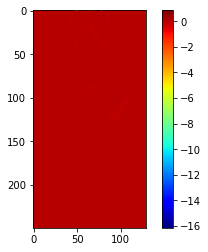

In [17]:
plt.figure()
plt.imshow(mom[0,10,...],'jet')
plt.colorbar()
plt.show()

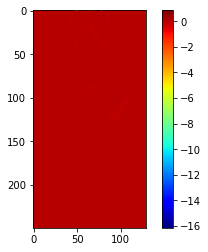

In [18]:
mom_ref = derivatives.momentum_residue_field(1,ux_train,uy_train,pp_train,datainfo)
plt.figure()
plt.imshow(mom_ref[10,...],'jet')
plt.colorbar()
plt.show()